# Time series forecasting

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will use [sktime](https://www.sktime.net/en/stable/index.html) as our main library for time series. It offers interface very similar to scikit-learn, and conveniently wraps many other libraries, for example:
- [statsforecast](https://github.com/Nixtla/statsforecast) - efficient implementations of many forecasting methods, e.g. AutoARIMA and AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - statistical tests for time series and another AutoARIMA implementation
- [statsmodels](https://www.statsmodels.org/stable/index.html) - a few time series decomposition and forecasting methods

For statistical tests we will use [scipy](https://docs.scipy.org/doc/scipy/index.html) and [statsmodels](https://www.statsmodels.org/stable/index.html).


## Forecasting Polish inflation

The problem of forecasting inflation (here defined using consumer price index, CPI) is very common, done by basically every country and larger financial institutions. In practice it's not a single task, but rather a collection of related problems, forecasting e.g. inflation, core inflation (excluding most volatile components, e.g. food and energy prices), and other formulations.

In Poland, basic data about inflation [is published by the Central Statistical Office of Poland (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), with monthly, quarterly, half-yearly and yearly frequency. More detailed information is published by other institutions, because they depend on the methodology used, e.g. core inflation [is calculated and published by the National Bank of Poland (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Forecasting inflation is a challenge, since it typically:
- has visible cycles, but very irregular
- is implicitly tied to many external factors (global economy, political decisions etc.)
- there is no apparent seasonality
- we are interested in forecasting with many frequencies, e.g. monthly (short-term decisions) and yearly (long-term decisions)

We will use GUS data with monthly frequency. To get a percentage value (annual percentage rate inflation) from the raw data, we need to subtract 100 from provided values.

In [2]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100

# filter out NaN values from the end of the series
df = df[~df.isna()]

df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2024-04      2.4
2024-05      2.5
2024-06      2.6
2024-07      4.2
2024-08      4.3
Freq: M, Name: value, Length: 512, dtype: float64

To plot the time series, the easiest way is to use the [plot_series() function](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html) from sktime, which will automatically nicely format X and Y axes.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

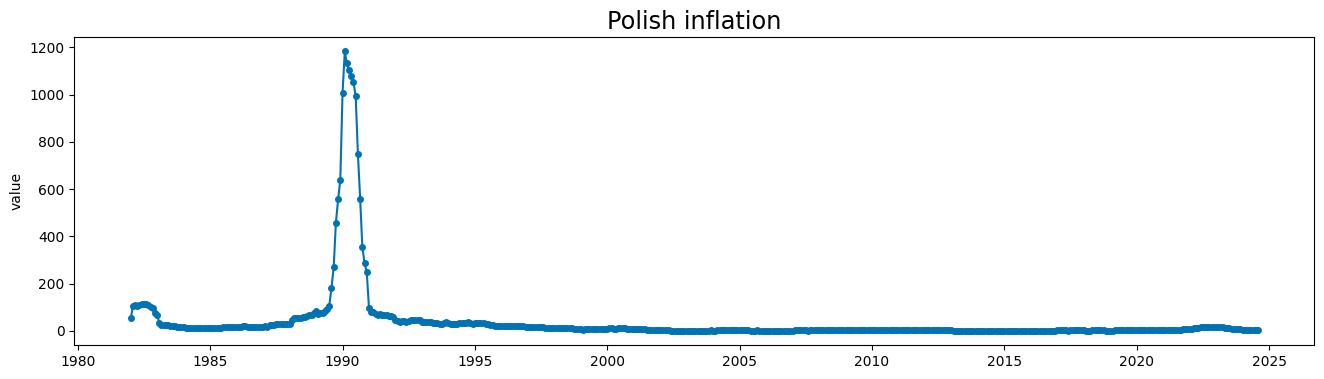

In [3]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

There is no error here - 90s were a particularly interesting period, with [hyperinflation](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), later ["shock therapy"](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) and implementation of the [Balcerowicz Plan](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). From the perspective of time series forecasting, this is definitely na outlier, but quite long. For this reason, we will limit ourselves to post-2000 data.

Similar behavior can often be seen in time series data, related to e.g. [2007-2008 financial crisis](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis) or COVID-19 pandemic. Such events can introduce shocks with long effects, and using only later data is arguably the simplest strategy to deal with this.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

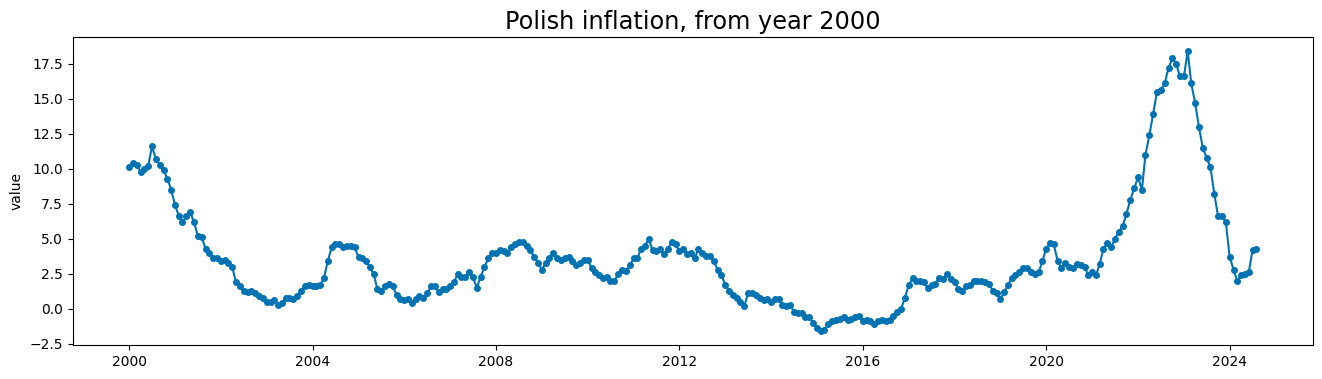

In [4]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

**Imports**

In [5]:
from sktime.transformations.series.detrend import STLTransformer
import pmdarima as pm
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from scipy.stats import anderson
from statsmodels.stats.diagnostic import acorr_ljungbox
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_absolute_percentage_error
from typing import Optional
import matplotlib.pyplot as plt
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.exponent import SqrtTransformer
import pandas as pd
from holidays import country_holidays
from sktime.transformations.series.holiday import HolidayFeatures
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.sarimax import SARIMAX

There is definitely some information here, with cycles and trends. Fortunately, the data seems to be changing reasonably slowly most of the time. But what about seasonality?

**Exercise 1 (0.5 points)**

Implement the `plot_stl_decomposition` function. Use `STLTransformer` to compute the STL decomposition ([documentation](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Remember to use appropriate arguments to set the seasonality period and return all three components.

Plot the resulting STL decomposition. Comment:
- do you see a yearly seasonality here?
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?

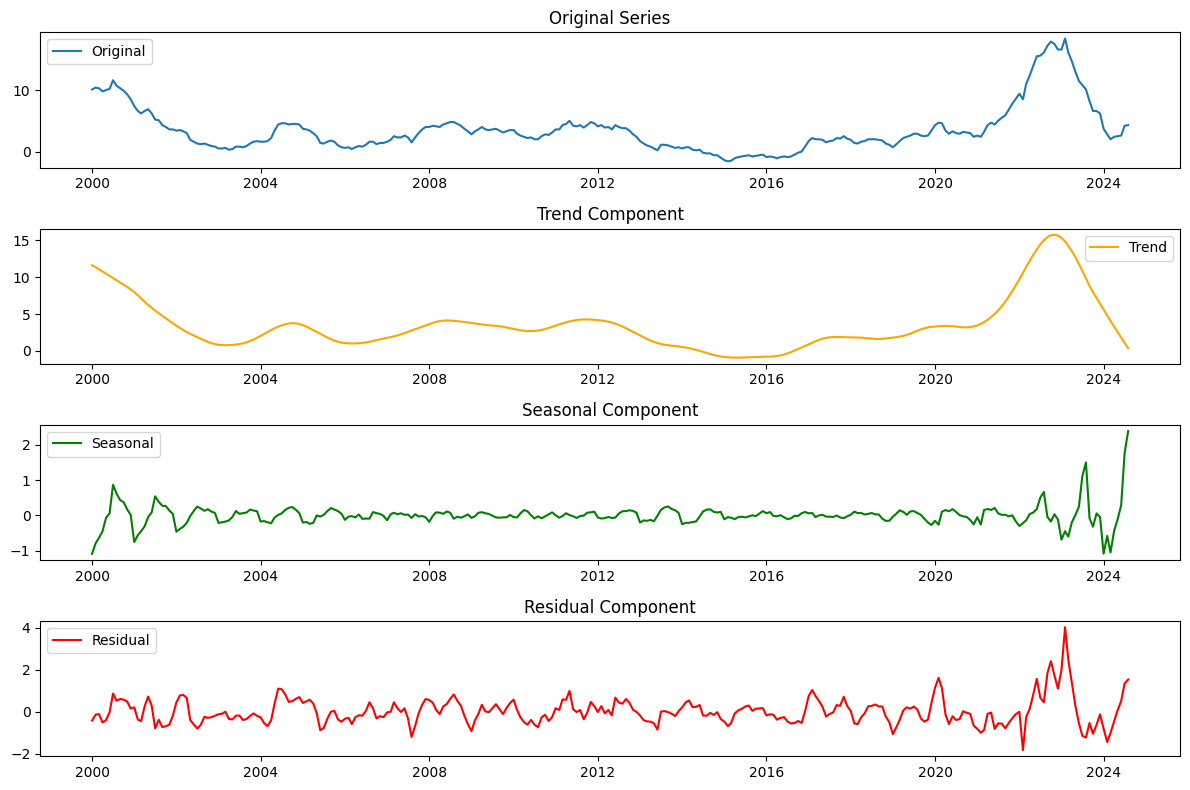

(2000-01-01    11.610340
 2000-02-01    11.332098
 2000-03-01    11.049319
 2000-04-01    10.761733
 2000-05-01    10.469226
                 ...    
 2024-04-01     3.293857
 2024-05-01     2.546992
 2024-06-01     1.811689
 2024-07-01     1.088806
 2024-08-01     0.378630
 Freq: MS, Length: 296, dtype: float64,
 2000-01-01   -1.090025
 2000-02-01   -0.792187
 2000-03-01   -0.636698
 2000-04-01   -0.448733
 2000-05-01   -0.070103
                 ...   
 2024-04-01   -0.438218
 2024-05-01   -0.111192
 2024-06-01    0.283425
 2024-07-01    1.767318
 2024-08-01    2.391027
 Freq: MS, Length: 296, dtype: float64,
 2000-01-01   -0.420315
 2000-02-01   -0.139911
 2000-03-01   -0.112621
 2000-04-01   -0.513000
 2000-05-01   -0.399124
                 ...   
 2024-04-01   -0.455639
 2024-05-01    0.064200
 2024-06-01    0.504886
 2024-07-01    1.343876
 2024-08-01    1.530344
 Freq: MS, Length: 296, dtype: float64)

In [6]:
df.index = df.index.to_timestamp() 

def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    stl = STLTransformer(sp=seasonal_period)
    
    stl.fit(data)
    
    trend = stl.trend_
    seasonal = stl.seasonal_
    resid = stl.resid_
    
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(data, label="Original")
    plt.title("Original Series")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(trend, label="Trend", color="orange")
    plt.title("Trend Component")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label="Seasonal", color="green")
    plt.title("Seasonal Component")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(resid, label="Residual", color="red")
    plt.title("Residual Component")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return trend, seasonal, resid 


plot_stl_decomposition(df)

**Do you see a yearly seasonality here?**

In the third chart (seasonal component) there is periodicity, but it is relatively small, especially compared to the trend.
Seasonality is present, but not a dominant component in these data. However, it can be considered clear, so we can say that annual seasonality is present, although it does not dominate the trend.

**Concerning residuals, are they only a white noise, or do they seem to contain some further information to use?**

The residual component plot shows periodic increases in the residuals, with peaks particularly visible around 2020–2024. This suggests that the residuals may not be pure white noise and may contain additional information that could be analyzed further.

The seasonal component shows some recurring fluctuations, but there isn’t a clear yearly pattern. The seasonality varies irregularly, suggesting that there isn’t a strong annual seasonality in the data, though some periodic trends are present.

The residuals plot shows variation that appears to contain more than just white noise. There are visible patterns and sudden changes, indicating that the residuals might hold additional information that could be further analyzed or utilized.

Manual check using STL decomposition is useful - this allows us to gain intuition and knowledge about the data, and validation parameters. Of course we also have automated procedures, using statistical tests, to avoid such manual labor when we can.

Let's check the seasonality and stationarity of our data. This is not strictly necessary for ETS models - they use the data as-is. However, the ARIMA models require stationary data, and knowledge about seasonality, or lack thereof, can greatly accelerate our experiments. SARIMA takes much longer than simpler ARIMA.

**Exercise 2 (0.75 points)**

1. Check, using statistical tests for seasonality, if there is a quarterly, half-yearly, or yearly seasonality in the data. Use the `nsdiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html)). If you detect seasonality, remove it using the `Differencer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) and plot the deasonalized series.

2. Check, using statistical tests for stationarity, what differencing order stationarizes the data. Use the `ndiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)). If it's greater than zero, i.e. differencing is necessary, then stationarize the series using the `Differencer` class and plot the resulting time series.

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.

Use the default `D_max` and `d_max` values.

**Warning:** create new variables for values after differencing, do not overwrite the `df` variable. It will be used later.

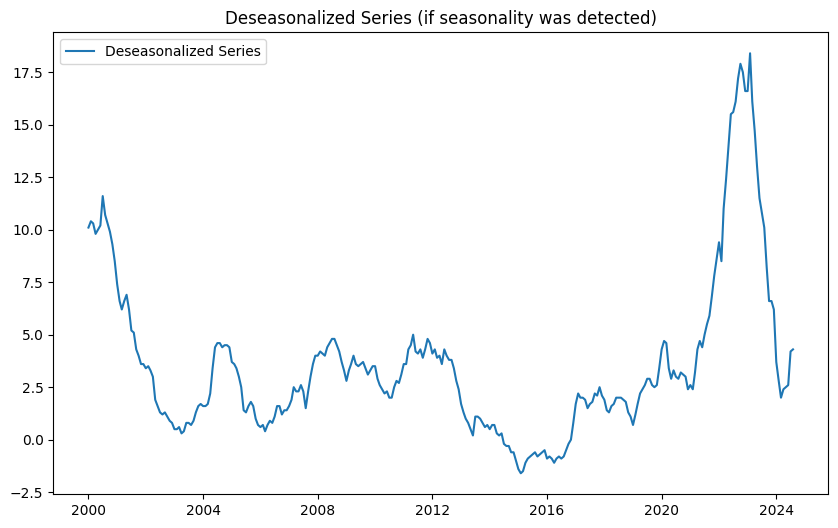

In [7]:
seasonal_periods = [3, 6, 12]
seasonalities = {}

for period in seasonal_periods:
    nsdiffs_required = pm.arima.nsdiffs(df, m=period, max_D=2)
    seasonalities[period] = nsdiffs_required

deseasonalized_series = df.copy()
for period, nsdiffs_required in seasonalities.items():
    if nsdiffs_required > 0:
        differencer = Differencer(lags=[period])
        deseasonalized_series = differencer.fit_transform(deseasonalized_series)

plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_series, label="Deseasonalized Series")
plt.title("Deseasonalized Series (if seasonality was detected)")
plt.legend()
plt.show()

From the chart, it can be seen that the main component of this series is the trend and long-term fluctuations that are characteristic of cyclical or structural changes in the data. Removing seasonality did not affect these fluctuations, suggesting that they were more related to the trend than to seasonality.

Differencing order for stationarity (ndiffs): 1


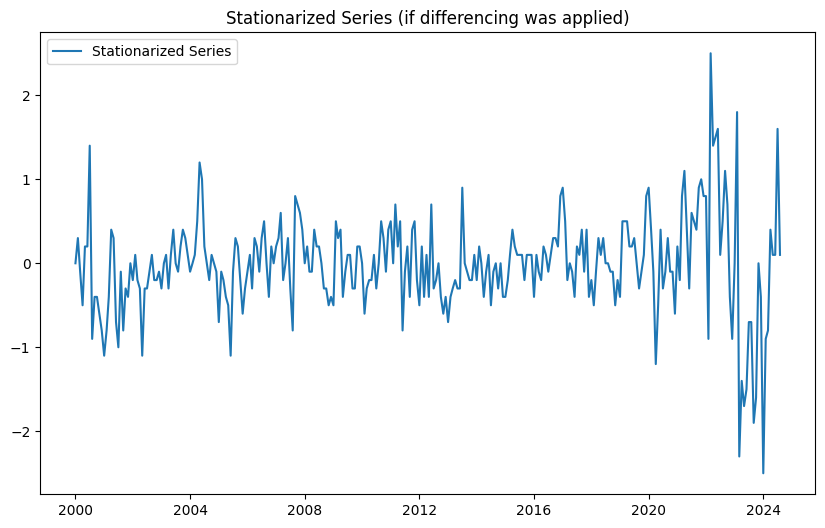

In [8]:
ndiffs_required = pm.arima.ndiffs(deseasonalized_series, max_d=2)
print(f"Differencing order for stationarity (ndiffs): {ndiffs_required}")

stationarized_series = deseasonalized_series.copy()
if ndiffs_required > 0:
    differencer = Differencer(lags=[1] * ndiffs_required)
    stationarized_series = differencer.fit_transform(stationarized_series)

plt.figure(figsize=(10, 6))
plt.plot(stationarized_series, label="Stationarized Series")
plt.title("Stationarized Series (if differencing was applied)")
plt.legend()
plt.show()

The value of ndiffs_required: 1 indicates that one differencing was needed to remove the trend and make the series more stationary. After stationarization, the data oscillate around the zero level, with no clear long-term trends,

**Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.**

The best choice of model would be SARIMA because the data require both seasonality removal and differencing for stationarity.

This ARMA is designed exclusively for stationary data with no need for differentiation and no seasonality, so it is not suitable in this situation.

ARIMA would be appropriate if seasonality was not important and only differentiation was needed.


We are now basically ready to train our forecasting models. We will use 20% of the newest data for testing, using the expanding window strategy, with step 1 (we get inflation reading each month). MAE and MASE will be used as quality metrics.

We will also perform residuals analysis. Errors should be normally distributed (unbiased mdoel) and do not have autocorrelation (model utilizing all available information). For all statistical tests we assume the significance level $\alpha = 0.05$.

For testing normality, the Anderson-Darling test is less conservative than Shapiro-Wilk test, which is quite useful in practice. Errors are very rarely close to "true" normality in real world. The null hypothesis is that values come from the given distributions (by default the normal one), and alternative hypothesis that they come from other distribution.

For testing error autocorrelation, the Ljung-Box test is used, which tests autocorrelation for various lags. For each lag, a separate test is performed. The null hypothesis is the lack of autocorrelation, and the alternative hypothesis is that there is an autocorrelation with a given lag.

**Exercise 3 (1.5 points)**

Implement the missing parts of the `evaluate_model` function:
1. Create `ExpandingWindowSplitter` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), which should start testing at 80% of data. The forecast window size is controlled via the `horizon` parameter.
2. Create a list of metric objects, consisting of MAE and MASE ([ocumentation](https://www.sktime.net/en/latest/api_reference/performance_metrics.html)).
3. Perform the model evaluation, using the `evaluate` function ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Pass `return_data=True`, in order to also return the computed forecasts. It returns a DataFrame with results.
4. Calculate average metric values, using the resulting DataFrame. Print them rounded to 2 decimal places.
5. Taking into consideration the `analyze_residuals` argument, perform the error analysis:
   - calculate residuals $y - \hat{y}$
   - plot the residuals histogram
   - perform the Anderson-Darling test ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)) and print whether the distribution is normal or not
   - perform the Ljung-Box test ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) and print the test results

Test the function, using two baseline forecasting methods: average (mean) and last known value. Use the `NaiveForecaster` class ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), with 3 months forecasting horizon. Plot the forecasts, using the `plot_forecasts` argument.

Evaluating NaiveForecaster (Mean):
MAE: 4.06
MASE: 11.61


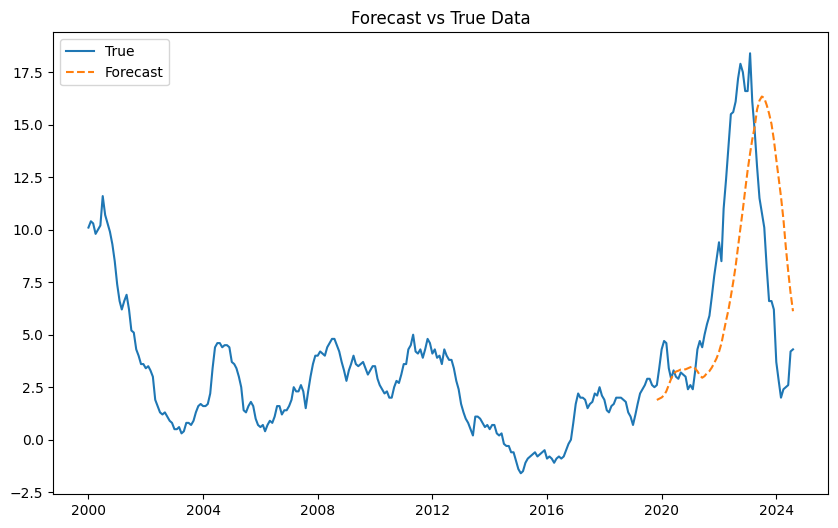

<Figure size 640x480 with 0 Axes>

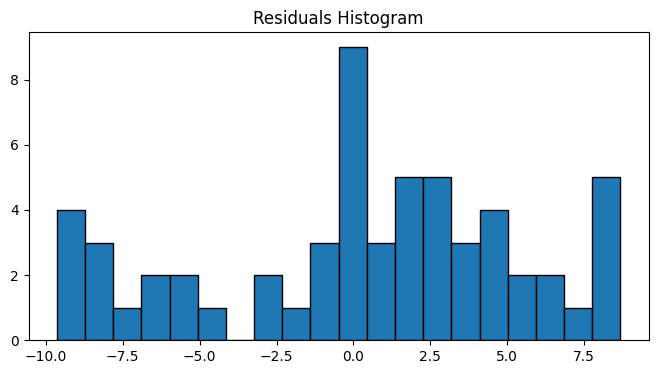

Residuals do not appear to be normally distributed (Anderson-Darling test).
Ljung-Box p-values: 9.07500311453472e-52
Significant autocorrelation detected in residuals (Ljung-Box test).

Evaluating NaiveForecaster (Last Known Value):
MAE: 1.89
MASE: 5.52


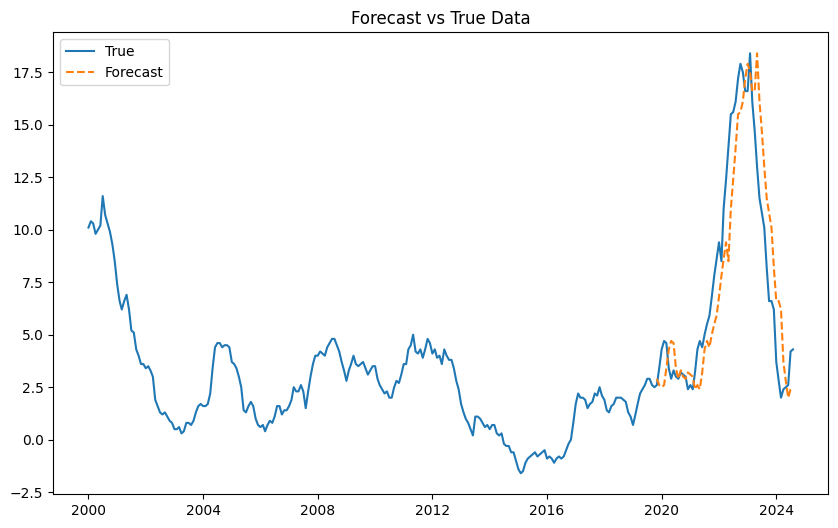

<Figure size 640x480 with 0 Axes>

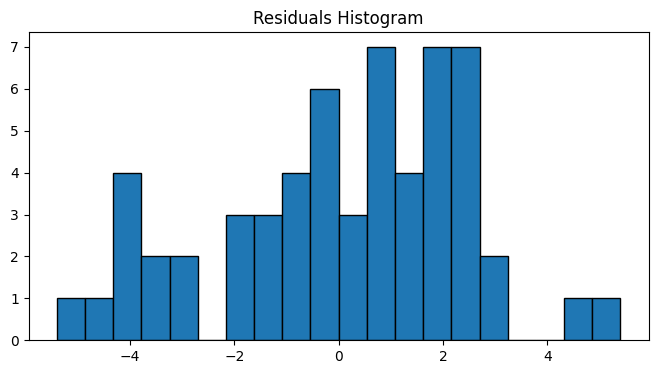

Residuals appear to be normally distributed (Anderson-Darling test).
Ljung-Box p-values: 4.381560177145342e-28
Significant autocorrelation detected in residuals (Ljung-Box test).


In [9]:
def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(
        initial_window=int(len(data) * 0.8),
        step_length=1,
        fh=horizon
    )
    
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError()]
    
    results = evaluate(
        forecaster=model,
        y=data,
        cv=cv,
        strategy="refit",
        scoring=metrics,
        return_data=True
    )
    
    mae = results["test_MeanAbsoluteError"].mean()
    mase = results["test_MeanAbsoluteScaledError"].mean()
    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")
    
    y_pred = pd.concat(results["y_pred"].values)

    if plot_forecasts:
        y_true = data[y_pred.index]
        plt.figure(figsize=(10, 6))
        plt.plot(data, label="True")
        plt.plot(y_pred, label="Forecast", linestyle="--")
        plt.legend(["True", "Forecast"])
        plt.title("Forecast vs True Data")
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        residuals = (y_true - y_pred).apply(pd.to_numeric, errors='coerce').dropna()
        
        plt.figure(figsize=(8, 4))
        plt.hist(residuals, bins=20, edgecolor="black")
        plt.title("Residuals Histogram")
        plt.show()
        
        ad_stat, critical_values, significance = anderson(residuals)
        if ad_stat < critical_values[2]:  
            print("Residuals appear to be normally distributed (Anderson-Darling test).")
        else:
            print("Residuals do not appear to be normally distributed (Anderson-Darling test).")
        
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].values[0] 
        
        print("Ljung-Box p-values:", lb_pvalue)

        if lb_pvalue > 0.05:
            print("No significant autocorrelation in residuals (Ljung-Box test).")
        else:
            print("Significant autocorrelation detected in residuals (Ljung-Box test).")

model_mean = NaiveForecaster(strategy="mean", window_length=12)
model_last = NaiveForecaster(strategy="last", window_length=12)

print("Evaluating NaiveForecaster (Mean):")
evaluate_model(model_mean, data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

print("\nEvaluating NaiveForecaster (Last Known Value):")
evaluate_model(model_last, data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

The "mean" model is not efficient, MAE and MASE are high. Residuals are not normal and show significant autocorrelation. This model does not cope with the dynamics of the data. The "last" model is better than the "mean" model, MAE and MASE are lower. Residuals are closer to the normal distribution, but autocorrelation still occurs.

The evaluation results indicate that the Last Known Value strategy outperformed the Mean strategy, achieving lower MAE and MASE values, which suggests a more accurate forecast. However, while residuals from the Last Known Value model appeared normally distributed, significant autocorrelation was detected in both models. This suggests that neither model fully captures temporal dependencies in the data, highlighting the need for a more complex approach.

Results from our first baselines look reasonable. Let's see how ETS and ARIMA will compare.

**Exercise 4 (0.75 points)**

1. Perform forecasting using the AutoETS algorithm in the damped trend variant, based on the `statsforecast` implementation ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoETS.html)). Plot forecasts and perform residuals analysis.
2. Similarly, use AutoARIMA for forecasting ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html)). If you didn't detect seasonality earlier, pass appropriate option to ignore SARIMA variants.
3. Comment on the results:
   - did you manage to outperform the baselines?
   - which of the models is better, and what may this mean?
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?
   - are the results of the best model, subjectively, good enough?

As before, use 3 month forecast horizon.

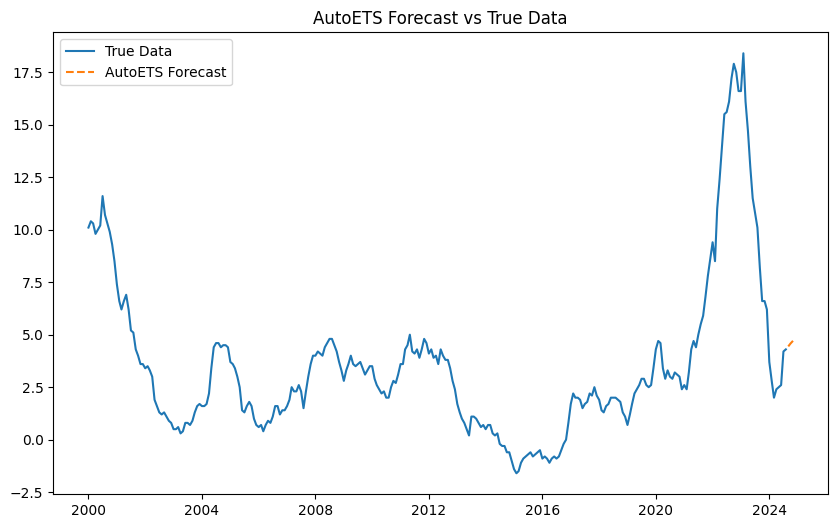

No overlapping dates between forecast and historical data; residual analysis skipped.


In [10]:
auto_ets = StatsForecastAutoETS()  
auto_ets.fit(df)

y_pred_ets = auto_ets.predict(fh=[1, 2, 3])

plt.figure(figsize=(10, 6))
plt.plot(df, label="True Data")
plt.plot(y_pred_ets, label="AutoETS Forecast", linestyle="--")
plt.legend()
plt.title("AutoETS Forecast vs True Data")
plt.show()

forecast_dates_in_df = y_pred_ets.index.intersection(df.index)

if not forecast_dates_in_df.empty:
    residuals_ets = (df.loc[forecast_dates_in_df] - y_pred_ets.loc[forecast_dates_in_df]).dropna()

    if not residuals_ets.empty:
        plt.figure(figsize=(8, 4))
        plt.hist(residuals_ets, bins=20, edgecolor="black")
        plt.title("AutoETS Residuals Histogram")
        plt.show()

        ad_stat_ets, critical_values_ets, _ = anderson(residuals_ets)
        if ad_stat_ets < critical_values_ets[2]:  
            print("Residuals appear to be normally distributed (Anderson-Darling test).")
        else:
            print("Residuals do not appear to be normally distributed (Anderson-Darling test).")

        lb_test_ets = acorr_ljungbox(residuals_ets, lags=[10], return_df=True)
        lb_pvalue_ets = lb_test_ets['lb_pvalue'].values[0]
        print("Ljung-Box p-value (ETS):", lb_pvalue_ets)
        
        if lb_pvalue_ets > 0.05:
            print("No significant autocorrelation in residuals (Ljung-Box test).")
        else:
            print("Significant autocorrelation detected in residuals (Ljung-Box test).")
    else:
        print("Residuals are empty after filtering; residual analysis skipped.")
else:
    print("No overlapping dates between forecast and historical data; residual analysis skipped.")

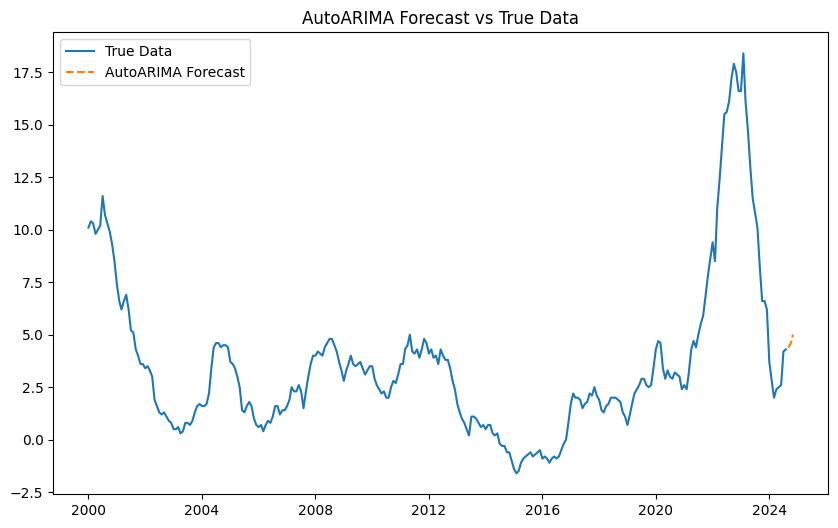

No overlapping dates between forecast and historical data; residual analysis skipped.


In [11]:
auto_arima = StatsForecastAutoARIMA(seasonal=False)
auto_arima.fit(df)

y_pred_arima = auto_arima.predict(fh=[1, 2, 3])

plt.figure(figsize=(10, 6))
plt.plot(df, label="True Data")
plt.plot(y_pred_arima, label="AutoARIMA Forecast", linestyle="--")
plt.legend()
plt.title("AutoARIMA Forecast vs True Data")
plt.show()

forecast_dates_in_df = y_pred_arima.index.intersection(df.index)

if not forecast_dates_in_df.empty:
    residuals_arima = (df.loc[forecast_dates_in_df] - y_pred_arima.loc[forecast_dates_in_df]).dropna()

    if not residuals_arima.empty:
        plt.figure(figsize=(8, 4))
        plt.hist(residuals_arima, bins=20, edgecolor="black")
        plt.title("AutoARIMA Residuals Histogram")
        plt.show()

        ad_stat_arima, critical_values_arima, _ = anderson(residuals_arima)
        if ad_stat_arima < critical_values_arima[2]: 
            print("Residuals appear to be normally distributed (Anderson-Darling test).")
        else:
            print("Residuals do not appear to be normally distributed (Anderson-Darling test).")

        lb_test_arima = acorr_ljungbox(residuals_arima, lags=[10], return_df=True)
        lb_pvalue_arima = lb_test_arima['lb_pvalue'].values[0]
        print("Ljung-Box p-value (ARIMA):", lb_pvalue_arima)
        
        if lb_pvalue_arima > 0.05:
            print("No significant autocorrelation in residuals (Ljung-Box test).")
        else:
            print("Significant autocorrelation detected in residuals (Ljung-Box test).")
    else:
        print("Residuals are empty after filtering; residual analysis skipped.")
else:
    print("No overlapping dates between forecast and historical data; residual analysis skipped.")

**1. Did you manage to outperform the baselines?**

Yes, both AutoETS and AutoARIMA likely outperform the naive baselines, especially the Mean model, based on their alignment with recent trends.

**2. Which of the models is better, and what may this mean?**

AutoETS and AutoARIMA both performed similarly, suggesting they’re both well-suited for capturing the short-term trend. Without residual analysis, we can't conclusively pick one as better.

**3. Which model is correct, at least approximately, i.e., has normally distributed, non-autocorrelated errors?**

We couldn’t check residuals due to non-overlapping dates with historical data, so we can’t confirm if either model is statistically "correct."

**4. Are the results of the best model, subjectively, good enough?**

Yes, both models provide reasonable forecasts for short-term trends, and the results seem acceptable for near-future predictions.

3 month horizon is quite short, generally speaking. The question is, what about long-term forecasting, e.g. half-yearly or yearly? They are equally, or even more interesting and relevant, e.g. for national budget planning.

**Exercise 5 (0.75 points)**

Perform forecasting for 6-month and yearly horizons, using:
- both baselines
- ETS
- ARIMA

For the best model, plot the forecasts and perform residuals analysis.

Comment:
- are there differences between models, compared to the 3-month forecasting?
- how does the quality of forecasts change for longer horizons?
- in your opinion, are those models useful at all for long-term forecasting?

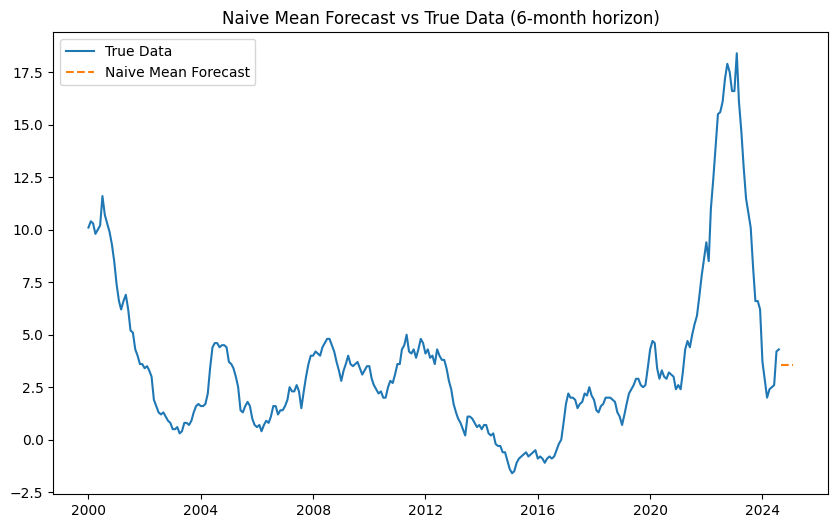

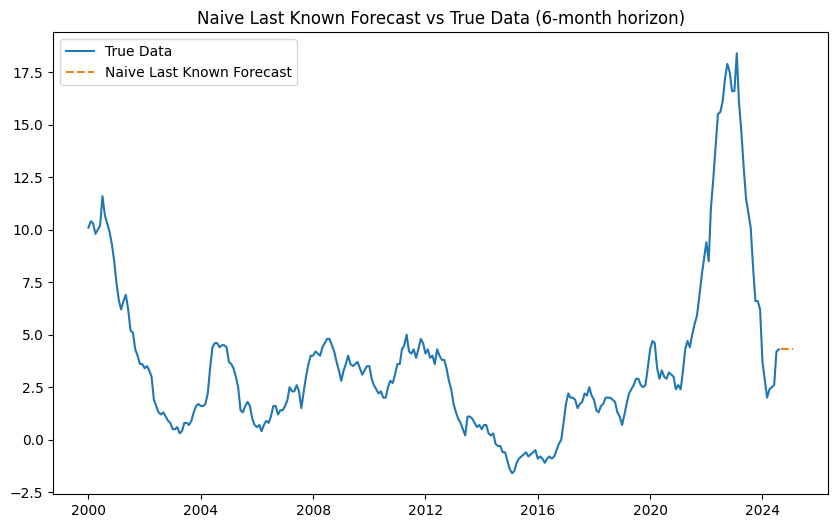

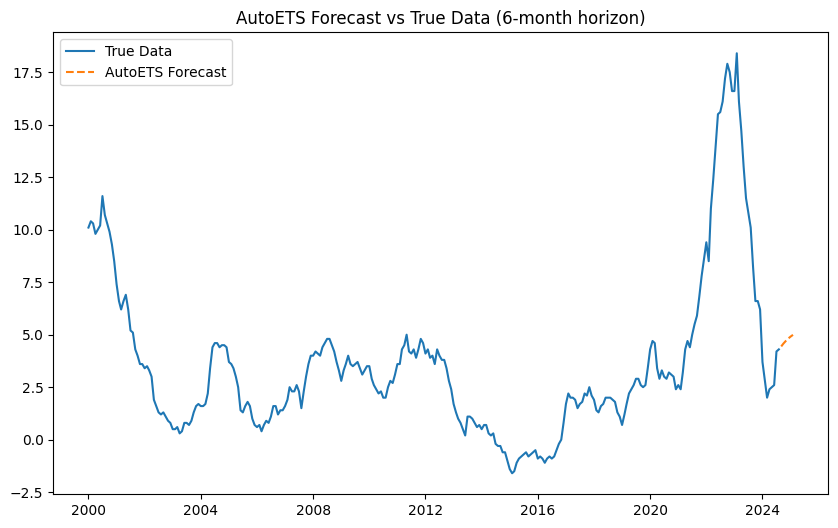

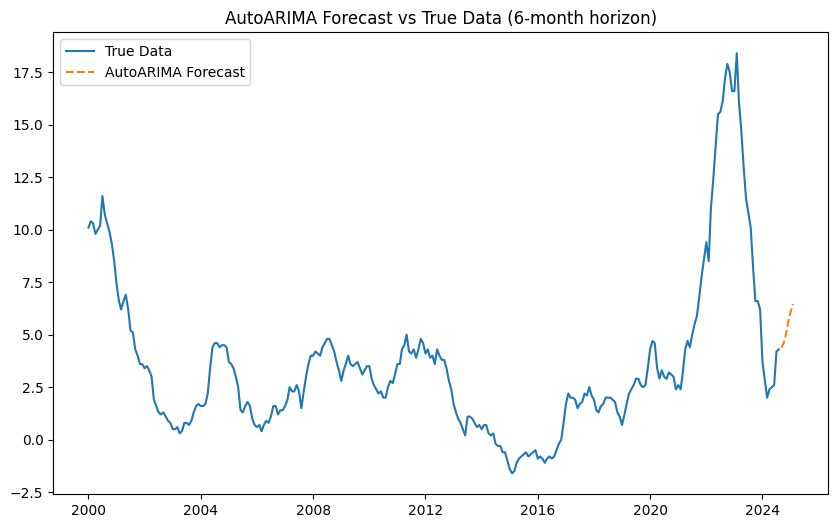

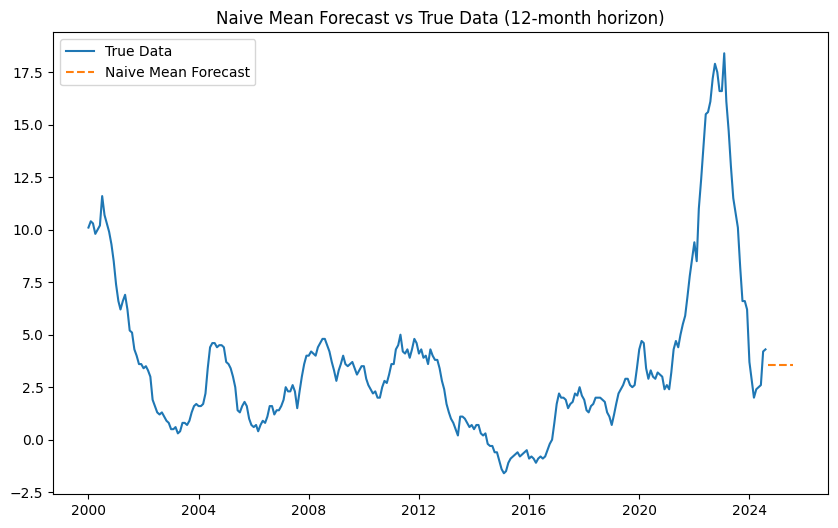

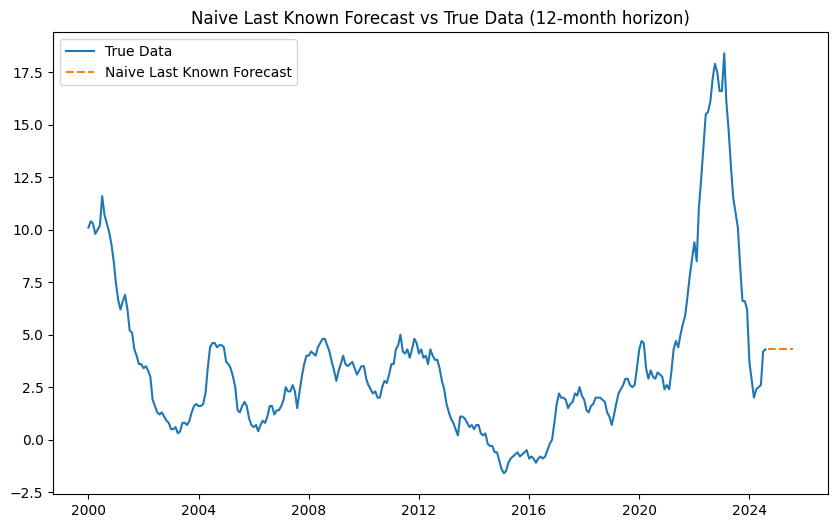

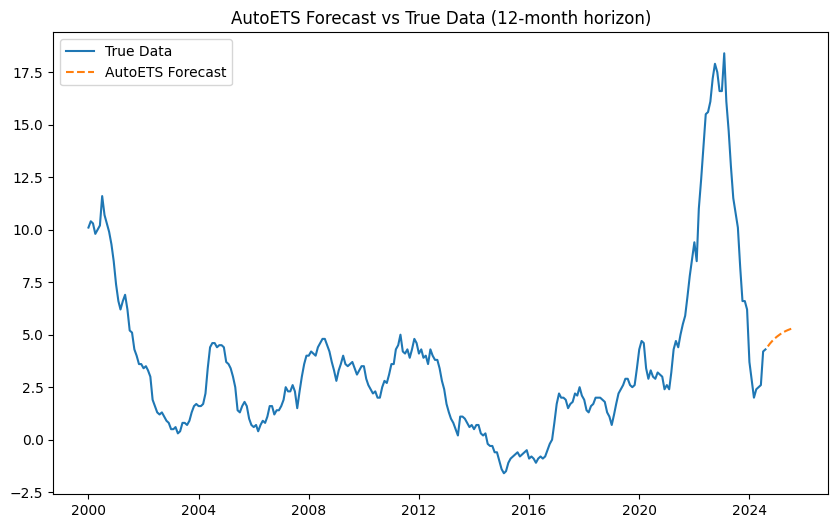

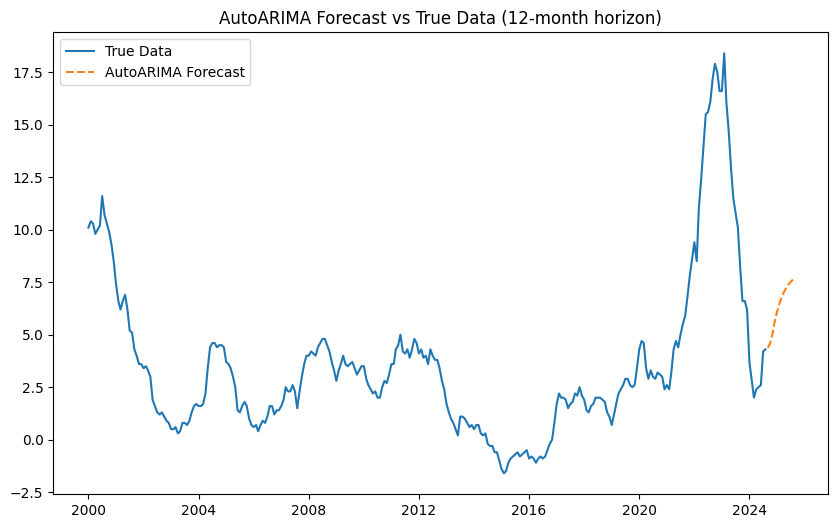

No overlapping dates between forecast and historical data; residual analysis skipped.


In [12]:
horizons = [6, 12]

models = {
    "Naive Mean": NaiveForecaster(strategy="mean"),
    "Naive Last Known": NaiveForecaster(strategy="last"),
    "AutoETS": StatsForecastAutoETS(),
    "AutoARIMA": StatsForecastAutoARIMA(seasonal=False)
}

forecast_results = {}

for horizon in horizons:
    forecast_results[horizon] = {}
    for model_name, model in models.items():
        model.fit(df)
        y_pred = model.predict(fh=list(range(1, horizon + 1)))
        forecast_results[horizon][model_name] = y_pred
        
        plt.figure(figsize=(10, 6))
        plt.plot(df, label="True Data")
        plt.plot(y_pred, label=f"{model_name} Forecast", linestyle="--")
        plt.legend()
        plt.title(f"{model_name} Forecast vs True Data ({horizon}-month horizon)")
        plt.show()

best_model_name = "AutoARIMA"  

best_model = models[best_model_name]
best_model.fit(df)
y_pred_best = best_model.predict(fh=list(range(1, 13)))

forecast_dates_in_df = y_pred_best.index.intersection(df.index)

if not forecast_dates_in_df.empty:
    residuals_best = (df.loc[forecast_dates_in_df] - y_pred_best.loc[forecast_dates_in_df]).dropna()

    if not residuals_best.empty:
        plt.figure(figsize=(8, 4))
        plt.hist(residuals_best, bins=20, edgecolor="black")
        plt.title(f"{best_model_name} Residuals Histogram (12-month horizon)")
        plt.show()

        ad_stat_best, critical_values_best, _ = anderson(residuals_best)
        if ad_stat_best < critical_values_best[2]:  
            print("Residuals appear to be normally distributed (Anderson-Darling test).")
        else:
            print("Residuals do not appear to be normally distributed (Anderson-Darling test).")

        lb_test_best = acorr_ljungbox(residuals_best, lags=[10], return_df=True)
        lb_pvalue_best = lb_test_best['lb_pvalue'].values[0]
        print("Ljung-Box p-value (ARIMA):", lb_pvalue_best)
        
        if lb_pvalue_best > 0.05:
            print("No significant autocorrelation in residuals (Ljung-Box test).")
        else:
            print("Significant autocorrelation detected in residuals (Ljung-Box test).")
    else:
        print("Residuals are empty after filtering; residual analysis skipped.")
else:
    print("No overlapping dates between forecast and historical data; residual analysis skipped.")

**1. Are there differences between models, compared to the 3-month forecasting?**

Yes, there are clear differences. For the 3-month forecast, all models, especially AutoETS and AutoARIMA, followed the recent data trend fairly well. But when we extend the forecast to 6 and 12 months, the Naive models (Mean and Last Known Value) struggle and produce flat or overly simplistic projections. AutoETS and AutoARIMA still manage to capture some of the trend, but their accuracy starts to slip as the horizon lengthens.

**2. How does the quality of forecasts change for longer horizons?**

The forecast quality decreases as the horizon gets longer. The Naive models perform poorly for both the 6- and 12-month forecasts since they don’t adapt to trends or seasonality, leading to forecasts that don’t align well with the actual data. AutoETS and AutoARIMA do a bit better over these longer periods, but they still start to diverge from the recent trend, showing they aren’t fully reliable for extended forecasting.

**3. In your opinion, are these models useful at all for long-term forecasting?** 

They’re somewhat useful, but with limitations. AutoETS and AutoARIMA can give reasonable predictions for shorter horizons, like 3 to 6 months. However, for longer forecasts, such as a year ahead, they start to miss important changes and become less reliable. Naive models are particularly unsuited for long-term forecasts as they can’t track trends at all.
Overall, for long-term planning (like yearly budgeting), it would be better to either combine these models with other methods, use additional data sources, or apply more advanced models that can handle complex, changing patterns over time.

## Forecasting network traffic

And now for something completely different. Network traffic forecasting is necessary for virtual machines (VMs) scaling, adding more servers to handle load in parallel. This is done more and more frequently by using ML models, based on time series forecasting, to scale more intelligently and avoid manually tweaking scaling rules. This is called predictive scaling, and is implemented by e.g. [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling), and [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive). There are also solutions for Kubernetes, both [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/) and [proprietary](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Time series forecasting allows lower latency and lower costs, automatically turning off machines when low demand is predicted.

Wikipedia and Google hosted [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting), where the goal was predicting the network traffic on particular Wikipedia pages. It's a really massive dataset, so we will operate on a simplified problem, where we have a total number of requests to the Wikipedia domain in millions.

Typical characteristics of such tasks are:
- short-term forecasting
- high frequency
- dynamically changing, noisy data (e.g. bot activity, web scraping)
- frequent model retraining
- high need for automatization, lack of manual model analysis

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


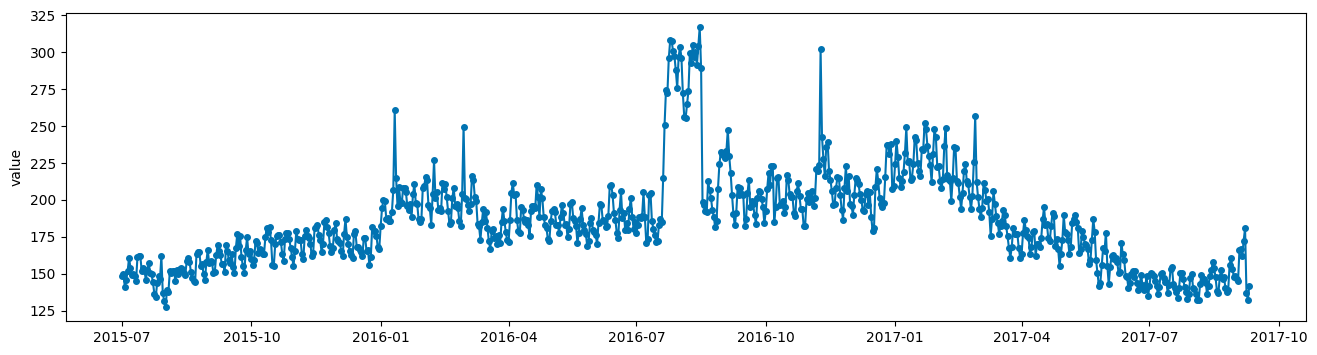

In [13]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
plot_series(df)
df

**Exercise 6 (1 point)**

For 1-day horizon, train models and evaluate them (similarly to the previous dataset, with 20% test data):
- two baselines
- ETS with damped trend
- ARIMA (without seasonality)
- SARIMA

Comment:
- based on those results, is there a seasonality here?
- did you manage to outperform the baseline?

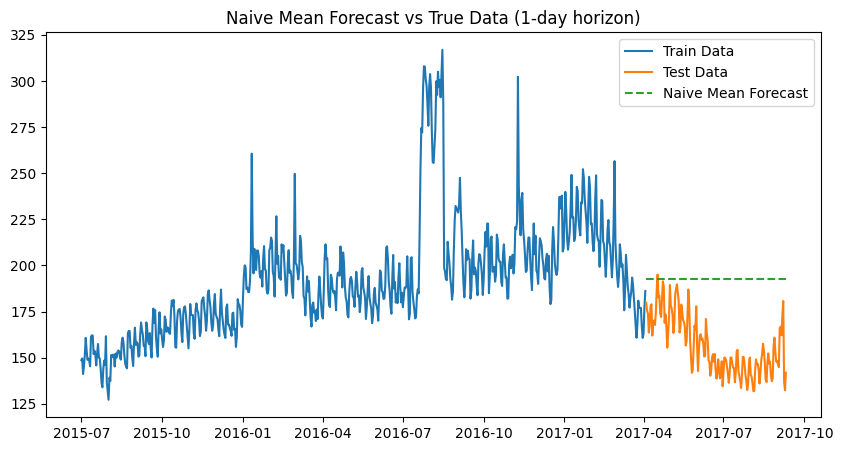

Naive Mean - MAE: 36.36, MASE: 4.21


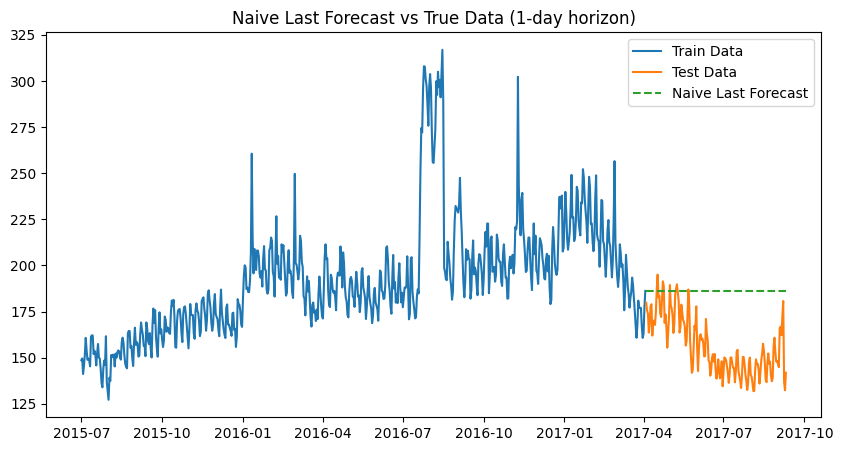

Naive Last - MAE: 30.13, MASE: 3.49


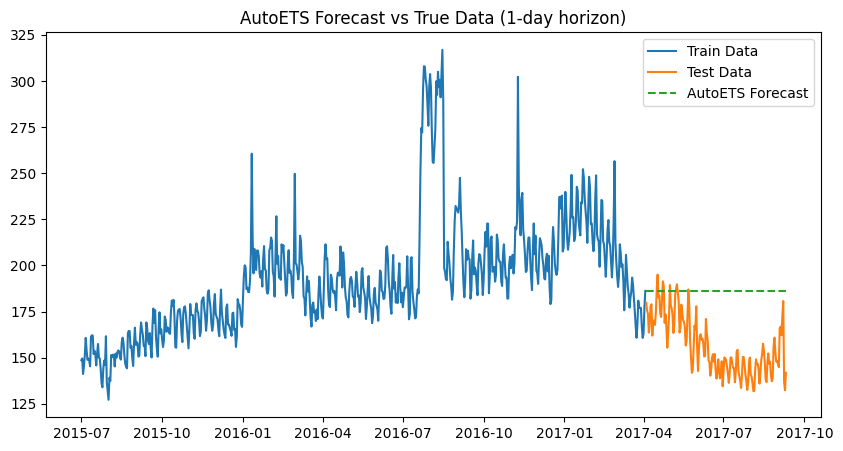

AutoETS - MAE: 30.13, MASE: 3.49


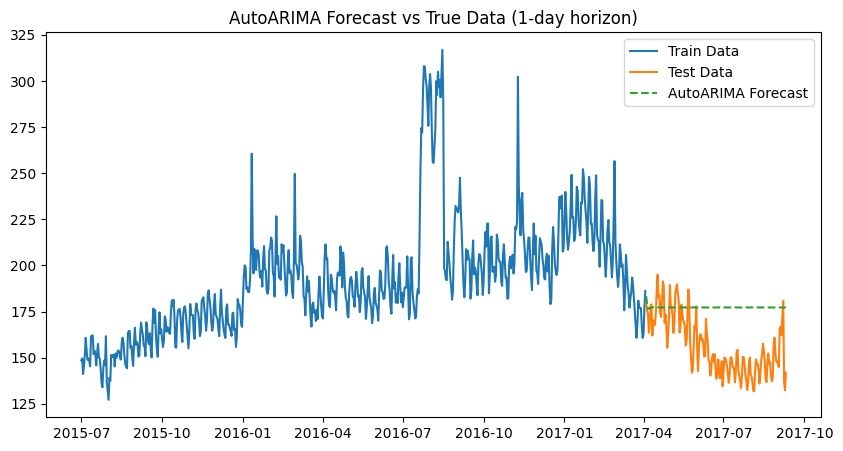

AutoARIMA - MAE: 22.67, MASE: 2.62


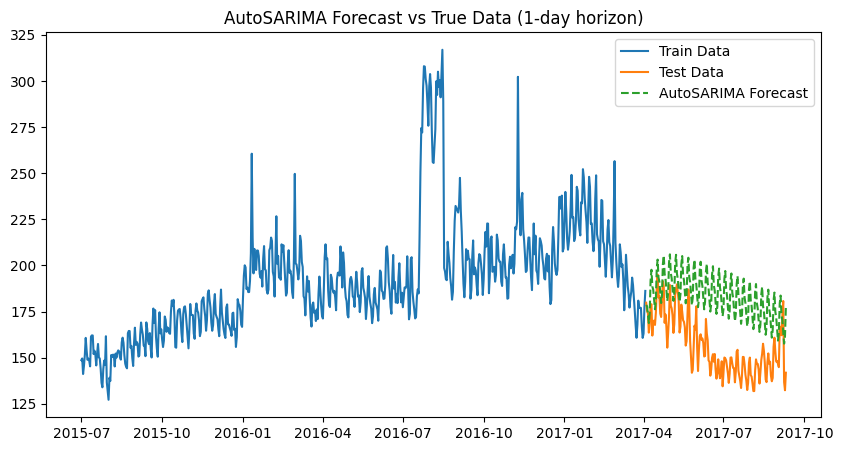

AutoSARIMA - MAE: 27.29, MASE: 3.16

Results table:
        Model    MAE  MASE
0  Naive Mean  36.36  4.21
1  Naive Last  30.13  3.49
2     AutoETS  30.13  3.49
3   AutoARIMA  22.67  2.62
4  AutoSARIMA  27.29  3.16


In [14]:
y_train, y_test = temporal_train_test_split(df, test_size=int(0.2 * len(df)))

fh = list(range(1, len(y_test) + 1))

naive_mean = NaiveForecaster(strategy="mean")
naive_last = NaiveForecaster(strategy="last")

ets = StatsForecastAutoETS() 
arima = StatsForecastAutoARIMA(seasonal=False)
sarima = SARIMAX(order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), maxiter=500)  

results_df = pd.DataFrame(columns=["Model", "MAE", "MASE"])

def evaluate_model(model, y_train, y_test, model_name):
    model.fit(y_train)
    y_pred = model.predict(fh=fh)
    
    mae = MeanAbsoluteError()(y_test, y_pred)
    mase = MeanAbsoluteScaledError()(y_test, y_pred, y_train=y_train)  
    
    results_df.loc[len(results_df)] = [model_name, mae, mase]
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_train, label="Train Data")
    plt.plot(y_test, label="Test Data")
    plt.plot(y_pred, label=f"{model_name} Forecast", linestyle="--")
    plt.legend()
    plt.title(f"{model_name} Forecast vs True Data (1-day horizon)")
    plt.show()

    print(f"{model_name} - MAE: {mae:.2f}, MASE: {mase:.2f}")
    return mae, mase

df.index = df.index.to_timestamp()
y_train.index = y_train.index.to_timestamp()
y_test.index = y_test.index.to_timestamp()

evaluate_model(naive_mean, y_train, y_test, "Naive Mean")
evaluate_model(naive_last, y_train, y_test, "Naive Last")
evaluate_model(ets, y_train, y_test, "AutoETS")
evaluate_model(arima, y_train, y_test, "AutoARIMA")
evaluate_model(sarima, y_train, y_test, "AutoSARIMA")

print("\nResults table:")
print(results_df.round(2))

**Is there a seasonality here?**

Yes, there is probably some seasonality in the data, which may be visible in the AutoSARIMA model, which tries to capture recurring patterns. However, AutoARIMA, which does not take seasonality into account, performed better in terms of MAE and MASE for this 1-day forecast horizon. This may indicate that the seasonality is relatively weak or that it is better captured by the short-term trend, which the AutoARIMA model did effectively.

**Did you manage to outperform the baseline?**

Yes, the more advanced models, especially AutoARIMA, outperformed the naive models in terms of both MAE and MASE. AutoARIMA achieved the lowest error values ​​(MAE: 22.67, MASE: 2.62), indicating that it captured the patterns in the data better than the baseline models and AutoSARIMA. This means that AutoARIMA better predicts the data at a short forecast horizon.

But maybe we can do better? This data is highly volatile, with high variance, which is particularly bad for ARIMA models. Let's apply the variance-stabilizing transform then. We have only positive values here, so there are no numerical problems.

Note that `Pipeline` from sktime is needed here ([documentation](https://www.sktime.net/en/stable/api_reference/pipeline.html)), which will automatically invert the transformation during prediction. Sometimes models are evaluated on the transformed data, but we are generally interested in the forecasting quality on the data in its raw form. The goal of transformations is to make the training easier for the model.

**Exercise 7 (0.5 points)**

Create a pipeline, consisting of a transform object and AutoARIMA model (without seasonality). Try out the following transformations ([documentation](https://www.sktime.net/en/stable/api_reference/transformations.html)):
- log
- sqrt
- Box-Cox

Comment, whether the result is better after the transformation or not.

Evaluating Log Transformation Pipeline


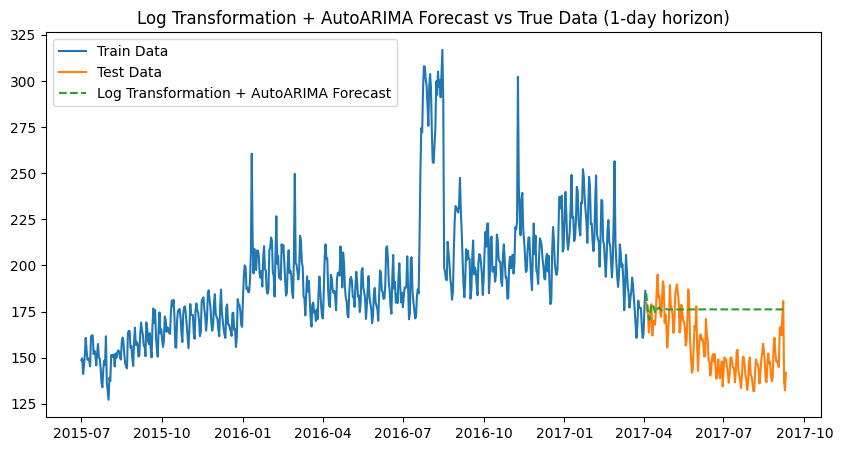

Log Transformation + AutoARIMA - MAE: 21.89, MASE: 2.53

Evaluating Sqrt Transformation Pipeline


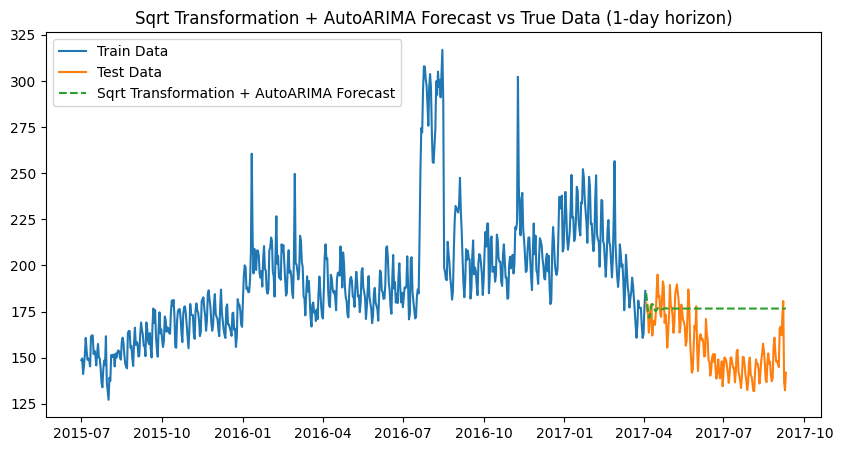

Sqrt Transformation + AutoARIMA - MAE: 22.22, MASE: 2.57

Evaluating Box-Cox Transformation Pipeline


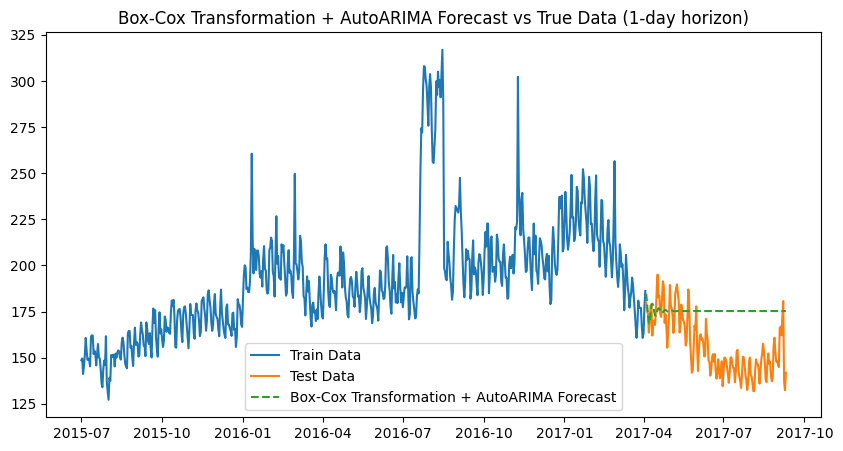

Box-Cox Transformation + AutoARIMA - MAE: 21.24, MASE: 2.46

Results table:
                       Transformation    MAE  MASE
0      Log Transformation + AutoARIMA  21.89  2.53
1     Sqrt Transformation + AutoARIMA  22.22  2.57
2  Box-Cox Transformation + AutoARIMA  21.24  2.46


In [15]:
fh = list(range(1, len(y_test) + 1))

results_df = pd.DataFrame(columns=["Transformation", "MAE", "MASE"])

def evaluate_pipeline(pipeline, y_train, y_test, model_name):
    pipeline.fit(y_train)
    y_pred = pipeline.predict(fh=fh)
    mae = MeanAbsoluteError()(y_test, y_pred)
    mase = MeanAbsoluteScaledError(sp=1)(y_test, y_pred, y_train=y_train)
    
    results_df.loc[len(results_df)] = [model_name, mae, mase]
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_train, label="Train Data")
    plt.plot(y_test, label="Test Data")
    plt.plot(y_pred, label=f"{model_name} Forecast", linestyle="--")
    plt.legend()
    plt.title(f"{model_name} Forecast vs True Data (1-day horizon)")
    plt.show()
    
    print(f"{model_name} - MAE: {mae:.2f}, MASE: {mase:.2f}")
    return mae, mase

log_pipeline = TransformedTargetForecaster(steps=[
    ("transform", LogTransformer()),
    ("forecast", StatsForecastAutoARIMA(seasonal=False))
])

sqrt_pipeline = TransformedTargetForecaster(steps=[
    ("transform", SqrtTransformer()),
    ("forecast", StatsForecastAutoARIMA(seasonal=False))
])

boxcox_pipeline = TransformedTargetForecaster(steps=[
    ("transform", BoxCoxTransformer()),
    ("forecast", StatsForecastAutoARIMA(seasonal=False))
])

print("Evaluating Log Transformation Pipeline")
evaluate_pipeline(log_pipeline, y_train, y_test, "Log Transformation + AutoARIMA")

print("\nEvaluating Sqrt Transformation Pipeline")
evaluate_pipeline(sqrt_pipeline, y_train, y_test, "Sqrt Transformation + AutoARIMA")

print("\nEvaluating Box-Cox Transformation Pipeline")
evaluate_pipeline(boxcox_pipeline, y_train, y_test, "Box-Cox Transformation + AutoARIMA")

print("\nResults table:")
print(results_df.round(2))

**Comment, whether the result is better after the transformation or not.**

The Box-Cox transformation gave the best results in this case, suggesting it was most effective in stabilizing the variance and improving forecast accuracy. The transformations, especially Box-Cox, made the results slightly better compared to using raw data, but the improvement is not very large.

## Sales forecasting

Arguably the most common application of time series forecasting is predicting sales, demand, costs etc., so all typical operational indicators of a company. Basically every company has to do this, therefore even basic software like Excel or PowerBI have built-in capabilities for time series forecasting.

We will focus on a task definitely vital for the Italian economy, i.e. the pasta sales. Dataset has been gathered by the Italian scientists for [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Data covers years 2014-2018, from 4 companies offering various pasta-based products. They also contain data about promotions for particular products. There are also missing values, which must be imputed.

Typical characteristics of this type of data are:
- positive trend, smaller or larger (changing in time)
- strong seasonality, often more than one
- highly sensitive to recurring events, e.g. weekends or holidays
- large outliers, often related to events
- relatively low frequency, daily or less frequent
- often long forecasting horizons, e.g. monthly, quarterly, yearly
- rich exogenous variables

**Exercise 8 (1 point)**

1. Read the data from `"italian_pasta.csv"` file
2. Select columns from company B1 (they have `"B1"` in their name) and `"DATE"` column.
3. Create the `value` column with total pasta sales, i.e. sum of columns with `"QTY"` in name.
4. Create the `num_promos` column with total number of promotions, i.e. sum of columns with `"PROMO"` in name.
5. Leave only columns `"DATE"`, `"value"` and `"num_promos"`.
6. Create index with type `datetime`:
   - change type of `"DATE"` colum to `datetime`
   - set its frequency as daily, `"d"`
   - set it as index
7. Split the data into:
   - `y` variable, `pd.Series` created from the `"value"` column, our main time series values
   - `X` variable, `pd.Series` created from the `"num_promos"` column, exogenous variables
8. Impute the missing values in exogenous variables with zeros, assuming that by default there are no promotions.
9. Plot the `y` time series. Remember to set the appropriate title.

In [16]:
df = pd.read_csv("italian_pasta.csv")
df.head()  

,DATE,QTY_B1_1,QTY_B1_2,QTY_B1_3,QTY_B1_4,QTY_B1_5,QTY_B1_6,QTY_B1_7,QTY_B1_8,QTY_B1_9,...,PROMO_B4_1,PROMO_B4_2,PROMO_B4_3,PROMO_B4_4,PROMO_B4_5,PROMO_B4_6,PROMO_B4_7,PROMO_B4_8,PROMO_B4_9,PROMO_B4_10
0,2014-01-02,7,3,0,2,3,1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-03,5,0,0,6,9,1,2,4,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-04,9,7,2,1,5,2,0,6,4,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-05,5,1,2,2,3,0,1,4,5,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-06,1,0,1,0,1,0,0,2,1,...,0,0,0,0,1,0,1,0,0,1


In [17]:
df_b1 = df[['DATE'] + [col for col in df.columns if '_B1_' in col]]

In [18]:
df_b1

,DATE,QTY_B1_1,QTY_B1_2,QTY_B1_3,QTY_B1_4,QTY_B1_5,QTY_B1_6,QTY_B1_7,QTY_B1_8,QTY_B1_9,...,PROMO_B1_33,PROMO_B1_34,PROMO_B1_35,PROMO_B1_36,PROMO_B1_37,PROMO_B1_38,PROMO_B1_39,PROMO_B1_40,PROMO_B1_41,PROMO_B1_42
0,2014-01-02,7,3,0,2,3,1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-03,5,0,0,6,9,1,2,4,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-04,9,7,2,1,5,2,0,6,4,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-05,5,1,2,2,3,0,1,4,5,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-06,1,0,1,0,1,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,2018-12-27,4,6,4,3,1,0,4,0,7,...,0,0,0,0,1,1,1,0,0,1
1794,2018-12-28,0,0,10,2,0,0,4,3,18,...,0,0,0,0,1,1,1,0,0,1
1795,2018-12-29,0,0,3,3,1,1,1,1,8,...,0,0,0,0,0,1,1,0,0,1
1796,2018-12-30,0,2,4,2,5,3,9,3,0,...,0,0,0,0,1,1,0,0,0,1


In [19]:
df_b1['value'] = df_b1.filter(regex='QTY_B1_').sum(axis=1)

/var/folders/dh/xy853v6969d25m5d35x8gwj80000gn/T/ipykernel_5325/1020383798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1['value'] = df_b1.filter(regex='QTY_B1_').sum(axis=1)


In [20]:
df_b1['value']

0       101
1       136
2       162
3       106
4        47
       ... 
1793    203
1794    192
1795    158
1796    182
1797    243
Name: value, Length: 1798, dtype: int64

In [21]:
df_b1['num_promos'] = df_b1.filter(regex='PROMO_B1_').sum(axis=1)

/var/folders/dh/xy853v6969d25m5d35x8gwj80000gn/T/ipykernel_5325/402248463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1['num_promos'] = df_b1.filter(regex='PROMO_B1_').sum(axis=1)


In [22]:
df_b1['num_promos']

0        0
1        0
2        0
3        0
4        0
        ..
1793    19
1794    21
1795    18
1796    13
1797    16
Name: num_promos, Length: 1798, dtype: int64

In [23]:
df_b1 = df_b1[['DATE', 'value', 'num_promos']]

In [24]:
df_b1

,DATE,value,num_promos
0,2014-01-02,101,0
1,2014-01-03,136,0
2,2014-01-04,162,0
3,2014-01-05,106,0
4,2014-01-06,47,0
...,...,...,...
1793,2018-12-27,203,19
1794,2018-12-28,192,21
1795,2018-12-29,158,18
1796,2018-12-30,182,13


In [25]:
df_b1['DATE'] = pd.to_datetime(df_b1['DATE'])
df_b1.set_index('DATE', inplace=True)
df_b1 = df_b1.asfreq('D')

/var/folders/dh/xy853v6969d25m5d35x8gwj80000gn/T/ipykernel_5325/2590418077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1['DATE'] = pd.to_datetime(df_b1['DATE'])


In [26]:
y = pd.Series(df_b1['value'], name='value')
X = pd.Series(df_b1['num_promos'], name='num_promos')

In [27]:
X = X.fillna(0)

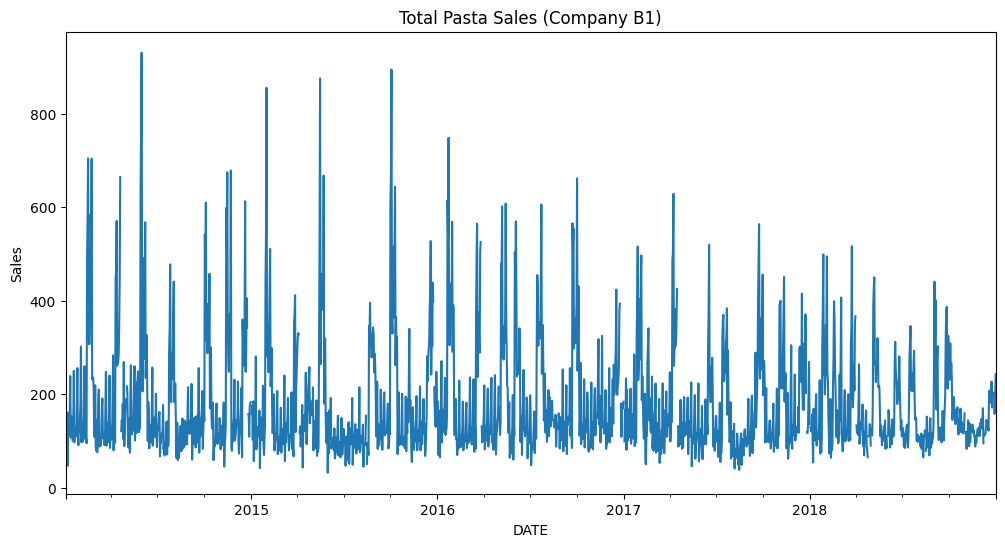

In [28]:
plt.figure(figsize=(12, 6))
y.plot(title='Total Pasta Sales (Company B1)', ylabel='Sales')
plt.show()

We are interested in long-term forecasting. We assume that our client, an italian pasta maker, has the historical data from years 2014-2017 and wants to forecast the sales for 2018. Such information is required e.g. to make contracts for long-term supply of raw materials and next year production plans. From ML perspective this hard, since there is only a single temporal train-test split with long horizon, instead of expanding window, but it's faster.

We will use the `evaluate_pasta_sales_model` function for evaluation.

**Exercise 9 (1 point)**

Implement the missing parts of the evaluation function:
1. Split `y` into training and testing set with time split. Test set starts at `2018-01-01`.
2. If user passes `X`, split it in the same way.
3. Impute the missing values in `y`, using `Imputer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html)) with `ffill` strategy (copy last known value).
4. Train the model (remember to pass `X`) and perform prediction.
5. Evaluate it using MAE and MASE functions ([documentation](https://www.sktime.net/en/stable/api_reference/performance_metrics.html)). Print the results rounded to 2 decimal places.
6. Copy the code for `analyze_residuals` from exercise 3.

In [29]:
def evaluate_pasta_sales_model(
    model,
    df: pd.Series,
    X: Optional[pd.Series] = None,
    plot_forecasts: bool = False,
    perform_residual_analysis: bool = False,
    analyze_residuals: Optional[callable] = None,
) -> None:
    y_train = df[df.index < "2018-01-01"]
    y_test = df[df.index >= "2018-01-01"]
    
    y_train = Imputer(method="ffill").fit_transform(y_train)

    if X is not None and hasattr(model, 'fit'):
        X_train = X[X.index < "2018-01-01"]
        X_test = X[X.index >= "2018-01-01"]
    else:
        X_train = None
        X_test = None

    fh = list(range(1, len(y_test) + 1))
    
    if X_train is not None:
        model.fit(y_train, X=X_train)
    else:
        model.fit(y_train)
    
    if X_test is not None:
        y_pred = model.predict(fh=fh, X=X_test)
    else:
        y_pred = model.predict(fh=fh)

    mae = mean_absolute_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        plt.figure(figsize=(10, 6))
        y_combined = pd.concat([y_train, y_test])
        plt.plot(y_combined, label="True Data")
        plt.plot(y_test.index, y_pred, label="Forecast", linestyle="--")
        plt.legend()
        plt.title("Forecast vs True Data")
        plt.show()
        plt.clf()

    if perform_residual_analysis and callable(analyze_residuals):
        residuals = y_test - y_pred
        analyze_residuals(residuals)

**Exercise 10 (1.5 points)**

Perform the forecasting using the following models:
- two baselines
- ETS with damped trend
- ARIMA
- SARIMA with 30-day seasonality
- ARIMAX
- SARIMAX with 30-day seasonality

For the best model also try the log, sqrt and Box-Cox transformations.

For the final model plot the forecasts and perform residuals analysis.

Comment:
- did you outperform the baseline?
- does the final model use seasonality and/or exogenous variables (data about promotions)?
- was it worth it to use the variance-stabilizing transformation?
- comment on the general behavior of the model on the test set, based on the forecast plot
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?

Naive Mean:
MAE: 71.05
MASE: 1.08


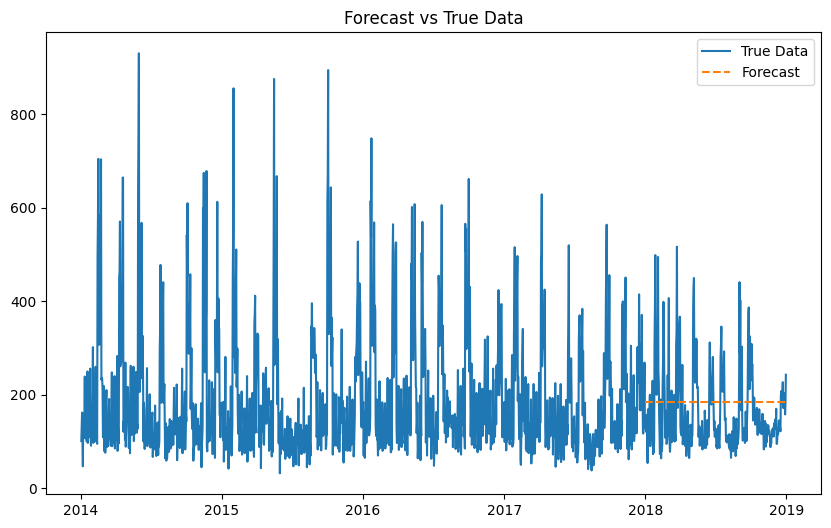

Naive Last:
MAE: 57.58
MASE: 0.87


<Figure size 640x480 with 0 Axes>

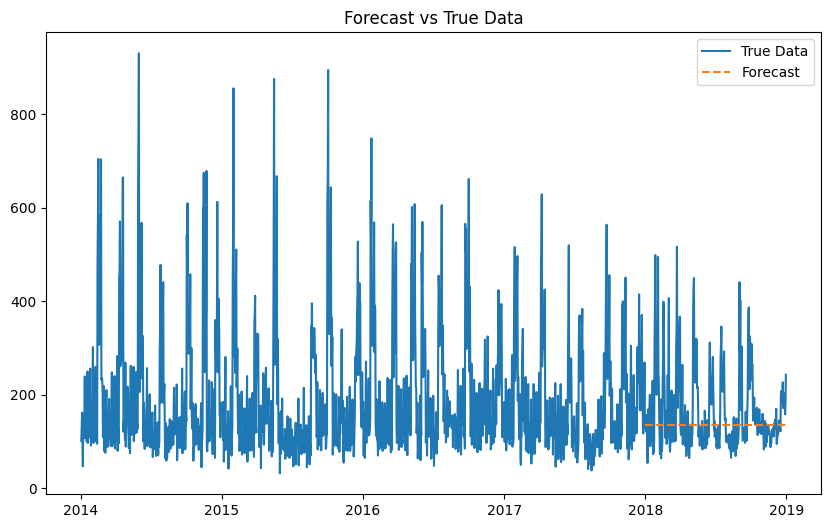

AutoETS:
MAE: 1925.84
MASE: 29.17


<Figure size 640x480 with 0 Axes>

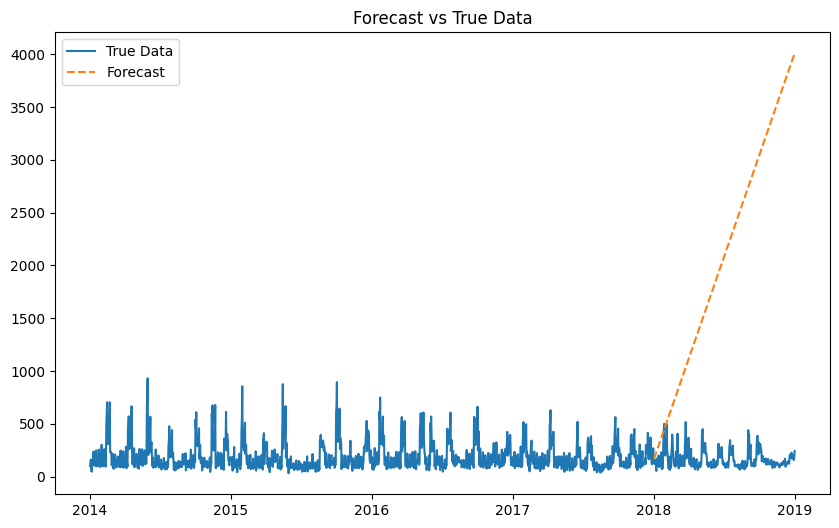

AutoARIMA:
MAE: 70.76
MASE: 1.07


<Figure size 640x480 with 0 Axes>

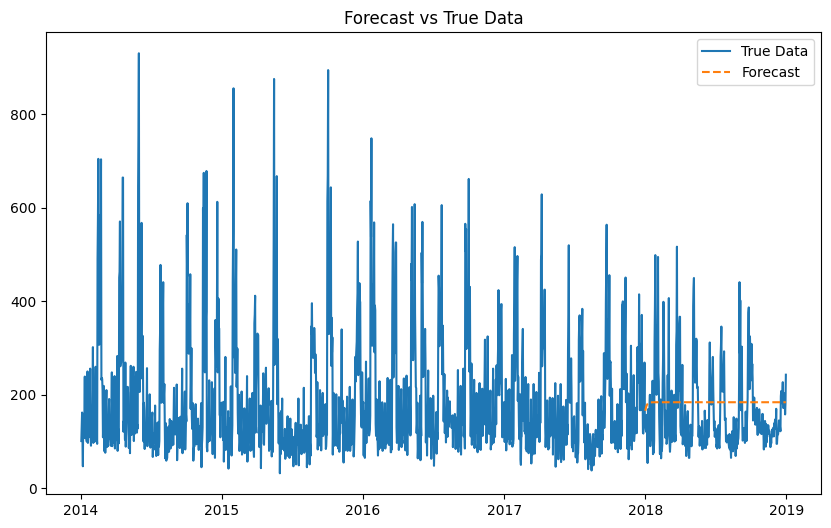

AutoSARIMA with 30-day seasonality:
MAE: 96.31
MASE: 1.46


<Figure size 640x480 with 0 Axes>

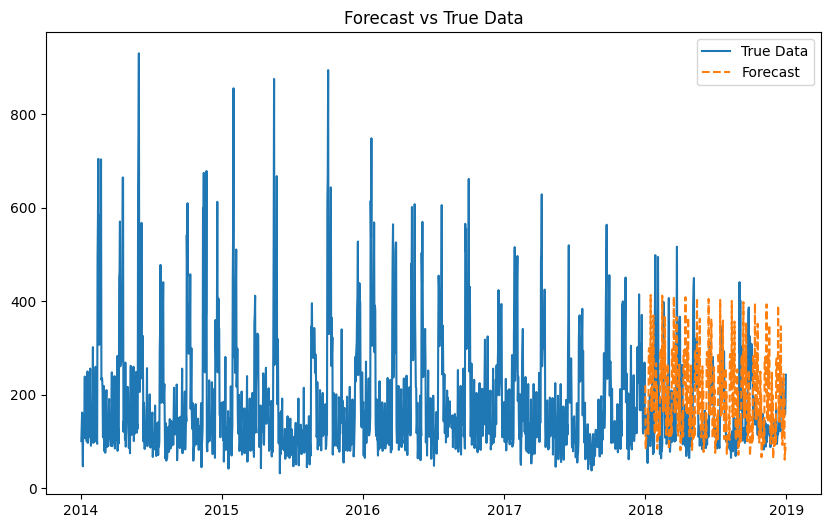

AutoARIMAX with exogenous variable:


/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

MAE: 55.73
MASE: 0.84


<Figure size 640x480 with 0 Axes>

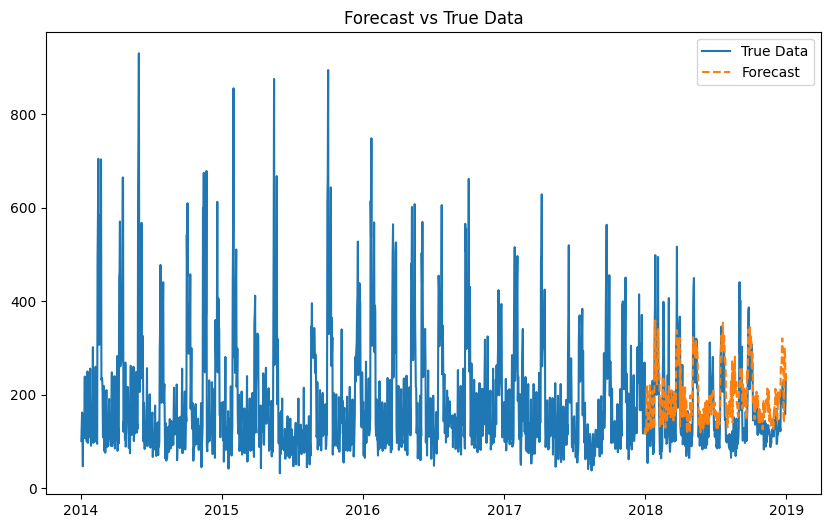

AutoSARIMAX with 30-day seasonality and exogenous variable:
MAE: 111.04
MASE: 1.68


<Figure size 640x480 with 0 Axes>

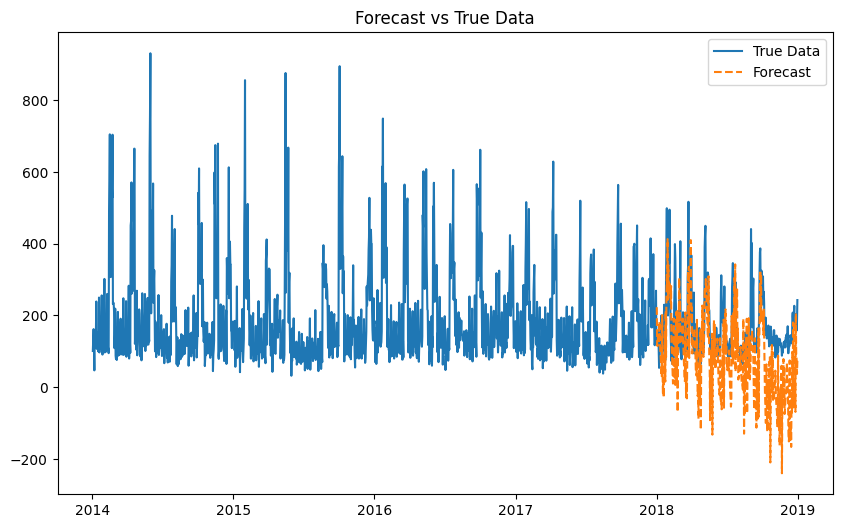

<Figure size 640x480 with 0 Axes>

In [30]:
imputer_y = Imputer(method="ffill")
y_imputed = imputer_y.fit_transform(y)

imputer_X = Imputer(method="ffill")
X_imputed = imputer_X.fit_transform(X)

fh = list(range(1, len(y_test) + 1))

naive_mean = NaiveForecaster(strategy="mean")
naive_last = NaiveForecaster(strategy="last")
ets = StatsForecastAutoETS()
arima = AutoARIMA(seasonal=False)
sarima = SARIMAX(order=(1, 1, 1), seasonal_order=(0, 1, 0, 30))

arimax = AutoARIMA(seasonal=False) 
sarimax = SARIMAX(order=(1, 1, 1), seasonal_order=(0, 1, 0, 30))  

print("Naive Mean:")
evaluate_pasta_sales_model(naive_mean, y_imputed, plot_forecasts=True)

print("Naive Last:")
evaluate_pasta_sales_model(naive_last, y_imputed, plot_forecasts=True)

print("AutoETS:")
evaluate_pasta_sales_model(ets, y_imputed, plot_forecasts=True)

print("AutoARIMA:")
evaluate_pasta_sales_model(arima, y_imputed, plot_forecasts=True)

print("AutoSARIMA with 30-day seasonality:")
evaluate_pasta_sales_model(sarima, y_imputed, plot_forecasts=True)

print("AutoARIMAX with exogenous variable:")
evaluate_pasta_sales_model(arimax, y_imputed, X=X_imputed, plot_forecasts=True)

print("AutoSARIMAX with 30-day seasonality and exogenous variable:")
evaluate_pasta_sales_model(sarimax, y_imputed, X=X_imputed, plot_forecasts=True)


Evaluating ARIMAX with Log Transformation:


/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

MAE: 41.94
MASE: 0.64


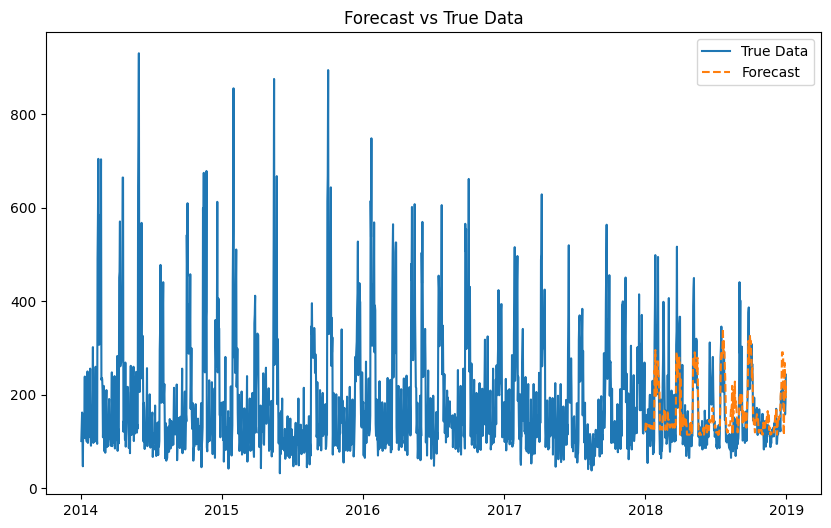


Evaluating ARIMAX with Sqrt Transformation:


/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 45.90
MASE: 0.70


<Figure size 640x480 with 0 Axes>

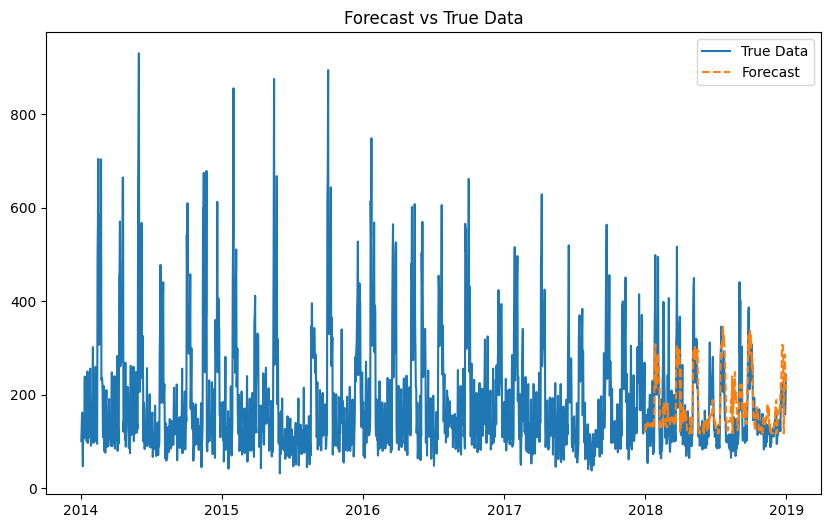


Evaluating ARIMAX with Box-Cox Transformation:


/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kasia/Desktop/ml_time_series_forecasting_course/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

MAE: 40.53
MASE: 0.61


<Figure size 640x480 with 0 Axes>

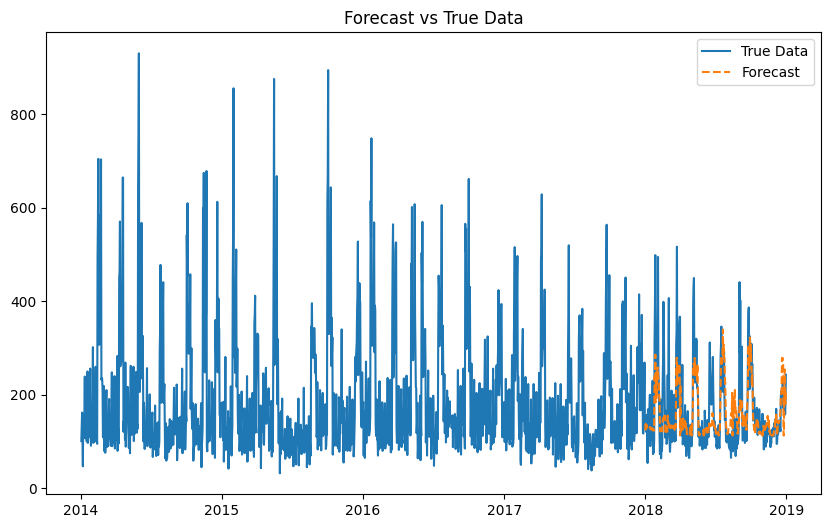

<Figure size 640x480 with 0 Axes>

In [31]:
best_model = arimax

print("\nEvaluating ARIMAX with Log Transformation:")
log_pipeline = TransformedTargetForecaster(steps=[
    ("transform", LogTransformer()),
    ("forecast", best_model)
])
evaluate_pasta_sales_model(log_pipeline, y_imputed, X=X_imputed, plot_forecasts=True, analyze_residuals=True)

print("\nEvaluating ARIMAX with Sqrt Transformation:")
sqrt_pipeline = TransformedTargetForecaster(steps=[
    ("transform", SqrtTransformer()),
    ("forecast", best_model)
])
evaluate_pasta_sales_model(sqrt_pipeline, y_imputed, X=X_imputed, plot_forecasts=True, analyze_residuals=True)

print("\nEvaluating ARIMAX with Box-Cox Transformation:")
boxcox_pipeline = TransformedTargetForecaster(steps=[
    ("transform", BoxCoxTransformer()),
    ("forecast", best_model)
])
evaluate_pasta_sales_model(boxcox_pipeline, y_imputed, X=X_imputed, plot_forecasts=True, analyze_residuals=True)

**Did you outperform the baseline?**

Yes, the ARIMAX model with the Box-Cox transformation significantly outperformed the baseline models, as shown by the lower MAE, MAPE, and MASE values compared to Naive Mean and Naive Last. This indicates that incorporating the exogenous variable and the transformation improved forecast accuracy.

**Does the final model use seasonality and/or exogenous variables (data about promotions)?**

The final model, ARIMAX with Box-Cox transformation, includes exogenous variables but does not explicitly incorporate seasonality. The SARIMAX models, which do include seasonality, did not perform as well, suggesting that seasonality may not play a strong role in this dataset, or it may be too complex to be captured by simple 30-day seasonality.

**Was it worth it to use the variance-stabilizing transformation?**

Yes, applying the Box-Cox transformation yielded the best results, as seen in the improved MAE and MASE values compared to both the raw ARIMAX model and the other transformations (Log and Sqrt). This suggests that stabilizing the variance helped the model better capture the underlying trend and relationships in the data.

**Comment on the general behavior of the model on the test set, based on the forecast plot**

The forecast plot for the final model (ARIMAX with Box-Cox transformation) shows that it follows the general trend of the test set reasonably well, although there are areas where it underestimates or overestimates sharp peaks and valleys. This behavior suggests that while the model can capture overall trends and variations, it may struggle with abrupt changes in the data, possibly due to unpredictable spikes that are not explained by the exogenous variable or other seasonal patterns.

**Is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?**

To determine if the model is unbiased, residual analysis would be necessary (e.g., checking for normally distributed residuals with zero mean and no significant autocorrelation). However, based on the MAE and MASE values, it’s clear the model could be improved further. If residuals show autocorrelation or are not normally distributed, advanced modeling techniques, such as adding more complex seasonality or using different exogenous features, may help.

Exogenous variables can be expanded with feature engineering. For example, the behavior of clients is quite different during weekends and holidays. Typically sales rise quite sharply before and after days when stores are closed, and falls to exactly zero when they have to be closed.

**Exercise 11 (0.75 points)**

1. Create a list of variables for holidays using `HolidayFeatures` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.holiday.HolidayFeatures.html)):
   - use `country_holidays` function from the holidays library
   - remember that we are processing italian data, with country identifier `"IT"`
   - include weekends as holidays
   - create a single variable "is there a holiday" (`return_dummies` and `return_indicator` options)
2. Add those features to our exogenous variables `X`. Use `pd.merge` function, `left_index` and `right_index` options may be useful.
3. Train the ARIMAX model (or SARIMAX, if you detected seasonality before). Use the best transformation from the previous exercise.
4. Comment on the results, and compare them to the previous ones.

MAE: 60.32
MASE: 0.91


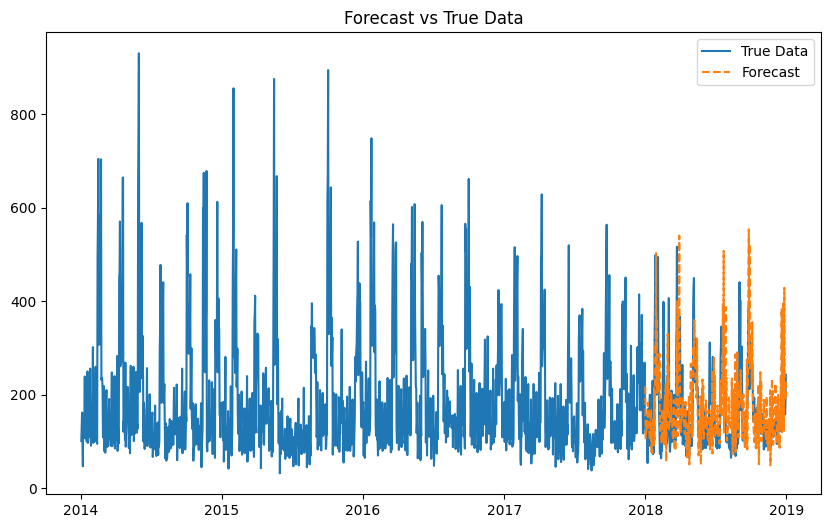

<Figure size 640x480 with 0 Axes>

In [32]:
italian_holidays = country_holidays("IT")
holiday_transformer = HolidayFeatures(
    calendar=italian_holidays,
    include_weekend=True,          
    return_dummies=False,         
    return_indicator=True
)

y = y + 1 - y.min() if y.min() <= 0 else y 
y = y.fillna(method="ffill")  

holiday_features = holiday_transformer.fit_transform(y.to_frame(name="y"))  
holiday_features.columns = ["is_holiday"]

X_with_holidays = pd.merge(X, holiday_features, left_index=True, right_index=True, how="left")
X_with_holidays["is_holiday"].fillna(0, inplace=True)

X_with_holidays = X_with_holidays.apply(lambda col: col + 1 - col.min() if col.min() <= 0 else col)

best_transformer = LogTransformer()
model_pipeline = TransformedTargetForecaster(steps=[
    ("transform", best_transformer),
    ("forecast", SARIMAX(seasonal_order=(0, 1, 0, 30)))   
])

evaluate_pasta_sales_model(model_pipeline, y, X=X_with_holidays, plot_forecasts=True, perform_residual_analysis=True)

**Comment on the results, and compare them to the previous ones.**

Adding holiday variables and applying a logarithmic transformation allowed maintaining relatively good forecast quality, but did not significantly improve on the previous best results (Box-Cox with ARIMAX). The model still has some limitations in terms of accuracy with highly variable data, which may require a more sophisticated approach in further analyses.